In [35]:
import numpy as np
import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
from scipy.special import comb
import h5py

# 1. Load Dataset

Run either 1.1 or 1.2 to load the review data of ICLR 2020 and ICLR 2021, respectively. In both cases, the signal space is $\{0,1,...,9\}$.

## 1.1 ICLR 2020

In [24]:
"""
The dataset contains more information, while we will only use the 'rating' attribute which contains the review scores for each submission.
"""
filename = 'Datasets/ICLR_2020.hdf5'
Reviews = [] # a list of numpy arraies each contains the reviews of every submission
with h5py.File(filename, "r") as f:
    a_group_key = list(f.keys())

    for key in a_group_key:
        review = []
        for j in list(f[key]['rating']):
            review.append(int(j-1))
        if len(review) == 0:
            continue
        Reviews.append(np.array(review))

print('Number of submissions: ', len(Reviews))

Number of submissions:  1565


## 1.2 ICLR 2021

In [23]:
file = open('Datasets/ICLR_2021.csv', "r")
csv_reader = csv.reader(file)
lists_from_csv = []
for row in csv_reader:
    lists_from_csv.append(row)

Reviews = []
pattern = re.compile(r'\d+')
for i in range(1,len(lists_from_csv)):
    Reviews.append((np.array(list(map(int, pattern.findall(lists_from_csv[i][3]))))-1).astype(int))

print('Number of submissions: ', len(Reviews))

Number of submissions:  2975


# 2. Learning the DS Model Parameters

The Dawid-Skene model has two parameters: 1) the prior distribution of paper quality, "w"; 2) the confusion matrix of the reviewers (Distribution of signals conditional on the true quality of the paper), "Gamma".

To learn the DS model, we use the EM algorithm. We first fix a number of categories, "L", and seperate the review data into a training set (80) and a test set (20). Then, we initialize "w" and "Gamma" and run the EM algorithm. Within each iteration, given "w" and "Gamma", we use the training set to learn a posterior quality distribution for each paper; then the posterior distributions are used to update "w" and "Gamma"; we also use "w" and "Gamma" to compute the likelihood of the test set. 

In the end, we output a list of DS model parameters for each "L" and each iteration. We use the likelihood of the each model to assess its performance.

Note that because of the randomness of seperation, each run will result in slightlt different parameters.

cross_validation_round 0
cross_validation_round 1
cross_validation_round 2
cross_validation_round 3
cross_validation_round 4


Text(0, 0.5, 'Likelihood')

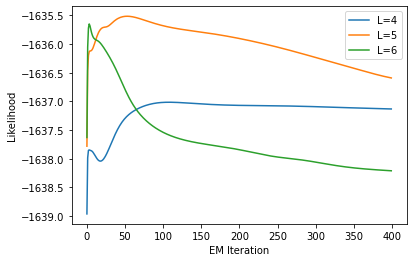

In [28]:
"""
Learning DS model from reviews with cross-validation
"""

def partition (list_in, k):
    """
    Input: "list_in" is a list;
           "k" is an integer, which indicates the number of subgroups of division.
    Output: a list of k divisions.
    The function randomly divids the input list "list_in" into k sublists with equal length (with error at most 1)
    """
    random.shuffle(list_in)
    return [list_in[i::k] for i in range(k)]

n = len(Reviews) # number of submissions
L_list = [4,5,6] # the list of the number of categories of paper quality
Reviews_division = partition(Reviews,5) # Divide the review set into 5 subsets

Likelihood = np.zeros((len(L_list),400))
w_list = [np.zeros((400,L)) for L in L_list]
Gamma_list = [np.zeros((400,L,10)) for L in L_list]


# Cross validation
for l in range(5):
    print('cross_validation_round',l)
    l_list = [0,1,2,3,4]
    l_list.remove(l)
    Reviews_train = []
    
    # pick l to be the test set, while the rest 4 subsets are combined as the training set
    for ll in l_list: 
        Reviews_train += Reviews_division[ll] 
    Reviews_test = Reviews_division[l]
    n_train = len(Reviews_train)
    n_test = len(Reviews_test)

    # Sort the training set based on the average review score
    ag = np.zeros(n_train)
    for i in range(n_train):
        ag[i] = np.average(Reviews_train[i])
    index = np.argsort(ag)
    Reviews_train = [Reviews_train[i] for i in index] 

    # For each of the number of quality categories 
    for ii,L in enumerate(L_list):

        w_train = np.ones(L)/L
        Gamma_train = np.zeros((L,10))
        Review_distribution_train = np.zeros((n_train,10))
        Gamma_uniform = np.ones((L,10))/10
        lam = 1e-3

        for i in range(n_train):
            Review_distribution_train[i] = np.bincount(Reviews_train[i], weights=None, minlength=10)

        # Divide the sorted training set into 5 equal subsets; Initialize Gamma using the empirical score distribution of each category.
        for s in range(L):
            review = Review_distribution_train[(s)*int(n_train/L):(s+1)*int(n_train/L)]
            Gamma_train[s] = np.sum(review, axis = 0)/np.sum(review)

        # EM algorithm
        t_train = np.zeros((n_train,L)) # the quality distribution of each paper in the training set
        
        # Iterate 400 times
        for step in range(400):
            
            # update the posterior of each paper given w and Gamma
            for i in range(n_train):
                p_gamma = np.ones(L)
                for s in Reviews_train[i]:
                    p_gamma *= Gamma_train[:,s]
                t_train[i] = w_train*p_gamma/np.sum(w_train*p_gamma)
                
            # Updata w and Gamma given the posterior of each paper
            w_train = np.average(t_train, axis = 0)
            Gamma_tmp = np.zeros((L,10))
            for i in range(n_train):
                for j in range(L):
                    Gamma_tmp[j] += Review_distribution_train[i]*t_train[i,j]
            for j in range(L):
                Gamma_tmp[j] = Gamma_tmp[j]/np.sum(Gamma_tmp[j])
                
            # Regularization to avoid overfitting
            Gamma_train = (1-lam)*Gamma_tmp + lam*Gamma_uniform
            
            # Compute the likelihood of the test set
            for i in range(n_test):
                li = w_train.copy()
                for s in Reviews_test[i]:
                    li *= Gamma_train[:,s]
                Likelihood[ii,step] += np.log(np.sum(li))/(T*5)
            w_list[ii][step] += w_train/(T*5)
            Gamma_list[ii][step] += Gamma_train/(T*5)


# Plot the likelihood on the test set
for ii,L in enumerate(L_list):
    index = np.argmax(Likelihood[ii])
    plt.plot(np.arange(400),Likelihood[ii],label='L='+str(L))
plt.legend()
plt.xlabel('EM Iteration')
plt.ylabel('Likelihood')

In [34]:
"""
Given a "L", pick the DS parameters that maximize the likelihood.
"""

########## Change L ##########
# One can change L as long as L is in L_list, e.g. L = 4, 5.
L = 4

l = np.where(np.array(L_list) == L)[0][0]
index = np.argmax(Likelihood[l])
w = w_list[l][index]
Gamma = Gamma_list[l][index]

# 3. Learn the Quality of Each Category

We attach each category of papers a value of their quality. To do so, we scale the average review score of each paper using an iversed sigmoid function. Then, we use the learned DS model to compute a distribution of categories for each paper. Finally, the value of quality attached to each category is the weighted average of the scaled review score.

In [ ]:
def inverse_sigmoid(x):
    return -np.log((9-x)/x)

# Compute the average review score of each paper and scale it with an inverse sigmoid function
Ag_score = np.zeros(n)
for i in range(n):
    Ag_score[i] = np.average(Reviews[i])
Ag_score_scaled = inverse_sigmoid(Ag_score)

# Compute the distribution of each paper's category
L = 4
t = np.zeros((n,L))
for i in range(n):
    p_gamma = np.ones(L)
    for s in Reviews[i]:
        p_gamma *= Gamma[:,s]
    t[i] = w*p_gamma/np.sum(w*p_gamma)

# Compute the quality value of each category
Q = np.zeros(L)
for i in range(n):
    Q += t[i]*Ag_score_scaled[i]
Q /= np.sum(t,axis = 0)
    
print('Prior of quality, w = ',np.round(w,4),'\n')
gamma_frame = np.round(Gamma,4)
df = pd.DataFrame(data=gamma_frame)
print('Confusion matrix, Gamma = ')
print(df,'\n')
print('Quality set = ',np.round(Q,4))

In [47]:
"""
Save the DS model parameters
"""

np.save('Learned Model/w_20_L4.npy', w)
np.save('Learned Model/Gamma_20_L4.npy', Gamma)
np.save('Learned Model/Q_20_L4.npy', Q)